### Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import r2_score
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

### Data Preprocessing

In [3]:
file_path = "C:/Users/Dell/Downloads/SY_NG/Myfile_dataA_5000.csv"
csvFile = pd.read_csv(file_path)

In [4]:
csvFile.shape

(5000, 9)

In [5]:
csvFile = csvFile.dropna()

In [6]:
csvFile.isna().sum()

Gate_Length          0
Work_function        0
Channel_Thickness    0
Oxide_Thickness      0
SD_doping            0
SUBSTRATE_doping     0
Gate_Voltage         0
Drain_Voltage        0
Drain Current        0
dtype: int64

In [7]:
csvFile.head()

,Gate_Length,Work_function,Channel_Thickness,Oxide_Thickness,SD_doping,SUBSTRATE_doping,Gate_Voltage,Drain_Voltage,Drain Current
0,1.220000e-08,4.606941,1.090000e-08,1.350000e-09,3.700000e+20,1.130000e+17,0.078664,0.216504,2.070000e-12
1,1.900000e-08,4.492014,1.090000e-08,1.360000e-09,4.060000e+20,2.210000e+17,0.496761,0.591274,2.120000e-12
2,1.080000e-08,4.331288,1.020000e-08,1.090000e-09,6.650000e+20,2.660000e+17,0.185672,0.798587,2.160000e-12
3,1.340000e-08,4.081299,1.010000e-08,1.200000e-09,4.820000e+20,2.490000e+17,0.166393,0.878277,2.210000e-12
4,1.440000e-08,4.254729,1.080000e-08,1.780000e-09,6.530000e+20,2.630000e+17,0.764250,0.111511,2.260000e-12


In [8]:
num_features = ["Gate_Length", "Work_function", "Channel_Thickness", "Oxide_Thickness", 
                "SD_doping", "SUBSTRATE_doping", "Gate_Voltage", "Drain_Voltage"]
X = csvFile[num_features]
y = csvFile["Drain Current"]

In [9]:
y = np.log1p(y)

### Data Splitting (80% Training Data and 20% Testing Data)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4000, 8) (4000,)
(1000, 8) (1000,)


### Model: Polynomial Regression

In [21]:
pipeline = make_pipeline(PolynomialFeatures(),
                         StandardScaler(),
                         PowerTransformer(method='yeo-johnson'),
                         Ridge())

In [23]:
param_grid = {
    'polynomialfeatures__degree': [3],
    'polynomialfeatures__interaction_only': [False],
    'polynomialfeatures__include_bias': [False],
    'ridge__alpha': np.logspace(-2, 0, 5),
    'ridge__solver': ['auto', 'cholesky', 'sag'],
    'ridge__max_iter': [1000],
    'ridge__tol': [1e-3]
}

In [24]:
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter=100, cv=5,
                                   scoring='r2', n_jobs=-1, random_state=0, verbose=2)
random_search.fit(x_train, y_train)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 15 is smaller than n_iter=100. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('polynomialfeatures',
                                              PolynomialFeatures()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('powertransformer',
                                              PowerTransformer()),
                                             ('ridge', Ridge())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'polynomialfeatures__degree': [3],
                                        'polynomialfeatures__include_bias': [False],
                                        'polynomialfeatures__interaction_only': [False],
                                        'ridge__alpha': array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ]),
                                        'ridge__max_iter': [1000],
                                        'ridge__solver': ['auto', 'cholesky',
                                                          'sag'],
                                        'ridge__tol': [0.001]},
                   random_state=0, scoring='r2', verbose=2)

In [25]:
best_lr = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'ridge__tol': 0.001, 'ridge__solver': 'auto', 'ridge__max_iter': 1000, 'ridge__alpha': 0.01, 'polynomialfeatures__interaction_only': False, 'polynomialfeatures__include_bias': False, 'polynomialfeatures__degree': 3}


In [26]:
y_pred = np.expm1(best_lr.predict(x_test))
y_test = np.expm1(y_test)

In [16]:
print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R² Score:', r2_score(y_test, y_pred))


Mean Absolute Error: 5.3747155339245594e-08
Mean squared Error: 4.755102896154861e-15
Root Mean Squared Error: 6.895725412278871e-08
R² Score: 0.9661705951572865


### Overfitting Analysis - Learning Curve and Cross-Validation

In [17]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(best_lr, X, y, cv=5, scoring='r2',
                                                        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)

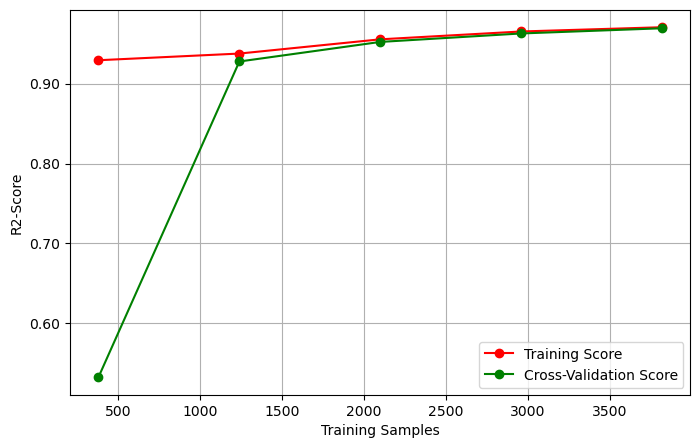

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-Validation Score')
plt.xlabel('Training Samples')
plt.ylabel('R2-Score')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.legend()
plt.grid()
plt.show()

### Model Inference Time

In [50]:
import time
import tensorflow as tf

num_inferences = 100
X_test_tensor = tf.convert_to_tensor(x_test)

start_time = time.time()

for _ in range(num_inferences):
    predictions = best_lr.predict(X_test_tensor)

end_time = time.time()

average_inference_time = (end_time - start_time) / num_inferences
print(f"Average inference time for ML model: {average_inference_time:.6f} seconds")

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does no

Average inference time for ML model: 0.177490 seconds


### SHAP

In [51]:
import shap

In [34]:
explainer = shap.Explainer(best_lr.predict, x_train)

In [44]:
shap_values = explainer(x_test)

ExactExplainer explainer: 1194it [12:52,  1.53it/s]                          


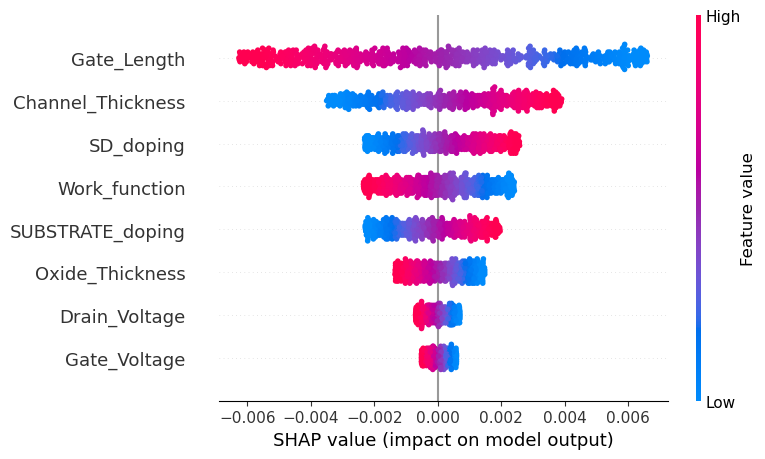

In [22]:
# Summary plot of feature importance
shap.summary_plot(shap_values, x_test, show=False)
plt.savefig("LR_shap_summary_plot.png", dpi=300, bbox_inches='tight')

In [23]:
shap_values.shape

(750, 8)

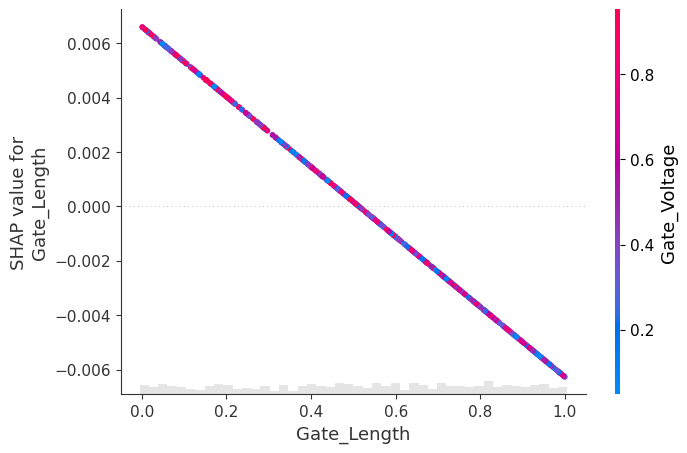

In [24]:
shap.plots.scatter(shap_values[:, 0], color=shap_values, show=False)
plt.savefig("LR_shap_scatter_plot_1.png", dpi=300, bbox_inches='tight')

In [25]:
shap.plots.waterfall(shap_values[749], show=False)
plt.savefig("LR_shap_waterfall_plot.png", dpi=300, bbox_inches='tight')

In [26]:
shap.plots.beeswarm(shap_values, show=False)
plt.savefig("LR_shap_beeswarm_plot.png", dpi=300, bbox_inches='tight')

### LIME

In [47]:
import lime
from lime import lime_tabular

In [49]:
lime_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train), feature_names=x_train.columns, 
                                                   mode='regression')

In [51]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')

In [53]:
j = 5
exp = explainer.explain_instance(x_test.values[j], poly_reg_model.predict, num_features=6)

Intercept 0.0994048431171913
Prediction_local [0.09972035]
Right: 0.10102354063551207


In [55]:
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
fig.savefig("LR_lime_explanation_plot_1.png", dpi=300, bbox_inches='tight')

In [57]:
exp.as_list()

[('Work_function <= 0.26', 0.0023018411710734447),
 ('0.48 < Gate_Length <= 0.74', -0.002210373611364245),
 ('0.49 < Channel_Thickness <= 0.74', 0.0012098840152784851),
 ('Oxide_Thickness > 0.76', -0.0011453825930133426),
 ('0.50 < SD_doping <= 0.75', 0.0010296660714624287),
 ('0.25 < SUBSTRATE_doping <= 0.50', -0.0008701256766006884)]

In [59]:
j = 5
exp = explainer.explain_instance(x_test.values[j], poly_reg_model.predict, num_features=6)

Intercept 0.10004440971118914
Prediction_local [0.09821193]
Right: 0.10102354063551207


In [61]:
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
fig.savefig("LR_lime_explanation_plot_2.png", dpi=300, bbox_inches='tight')

In [63]:
exp.as_list()

[('Work_function <= 0.26', 0.0022901223528388635),
 ('0.48 < Gate_Length <= 0.74', -0.002060579928952335),
 ('Oxide_Thickness > 0.76', -0.0014529230245308644),
 ('0.49 < Channel_Thickness <= 0.74', 0.001124869517395341),
 ('0.25 < SUBSTRATE_doping <= 0.50', -0.0009830604922601764),
 ('Drain_Voltage > 0.76', -0.0007509037219240413)]

### How Polynomial Regression Model Influences eXplainable AI (XAI)

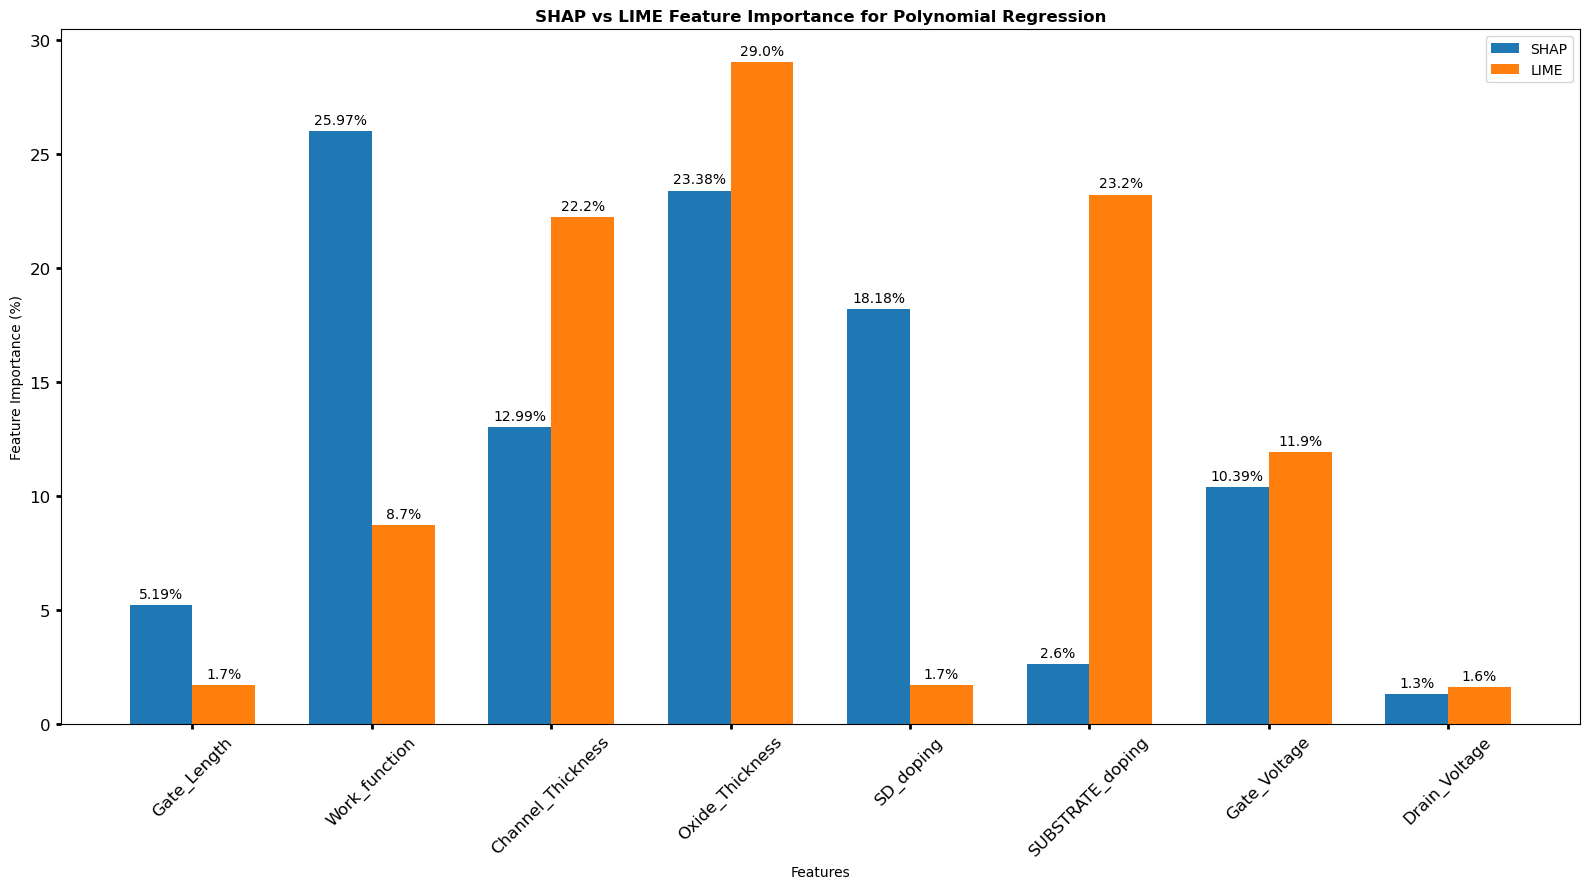

In [65]:
features = ['Gate_Length', 'Work_function', 'Channel_Thickness', 'Oxide_Thickness',
            'SD_doping', 'SUBSTRATE_doping', 'Gate_Voltage', 'Drain_Voltage']

shap_values = {
    'Polynomial Regression': [5.19, 25.97, 12.99, 23.38, 18.18, 2.60, 10.39, 1.30],
}

lime_values = {
    'Polynomial Regression': [1.7, 8.7, 22.2, 29.0, 1.7, 23.2, 11.9, 1.6],
}

def plot_feature_importance(shap_values, lime_values, model_name):
    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 9))
    
    rects1 = ax.bar(x - width/2, shap_values, width, label='SHAP')
    rects2 = ax.bar(x + width/2, lime_values, width, label='LIME')

    ax.set_xlabel('Features')
    ax.set_ylabel('Feature Importance (%)')
    ax.set_title(f'SHAP vs LIME Feature Importance for {model_name}', fontweight='bold')
    
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=12, width=2)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

for model_name in shap_values.keys():
    plot_feature_importance(shap_values[model_name], lime_values[model_name], model_name)